# Mortality Rate Prediction Using Neural Networks

## 1. Introduction

The project will use past population data to predict future mortality rates for Australia. This is a regression type problem with mortality rates (mx) regressed against the year (t). 

## 2. Data Preparation

### 2.1 Load packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from copy import deepcopy
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import Input, Embedding, Reshape, Dense, Concatenate
from tensorflow.keras.regularizers import l1

from sklearn.metrics import confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay

### 2.2 Load data
The project uses the Australia population data set available on Human Mortality Databse (HMD) - labelled as "AUS".

Steps before importing csv into Python:
1. Download the data from website https://www.mortality.org/File/GetDocument/hmd.v6/AUS/STATS/Mx_1x1.txt -> RAW
2. Remove header rows -> EDITTED TXT
3. Open in Excel and convert to CSV using " " delimiter
4. Add headers back in

In [2]:
country = 'AUS'
gender = 'Female'

all_mort = pd.read_csv(f"{country}_mort.csv")

if (country == 'CHE'):
    all_mort.drop(columns = ['Country','imputed_flag','logmx'], inplace = True)
    all_mort = all_mort.pivot(index=['Year','Age'], columns='Gender')['mx'].reset_index()
    all_mort.columns.name = None
all_mort.head()


,Year,Age,Female,Male,Total
0,1921,0,0.059987,0.076533,0.068444
1,1921,1,0.012064,0.014339,0.013225
2,1921,2,0.005779,0.006047,0.005916
3,1921,3,0.002889,0.004197,0.003554
4,1921,4,0.003254,0.003254,0.003254


### 2.3 Data Formatting
- Replace "." with NA
- Encode age bracket "110+" as 110 - will be removed later on as we are investigating ages 0 to 99
- Converting age, mx and gender to int, float and category respectively

In [3]:
# make data wider to longer
all_mort = all_mort.melt(id_vars=['Year','Age'], value_vars =['Female','Male'], var_name = "Gender", value_name='mx')

#change 110+ to 110
all_mort.loc[all_mort['Age'] == '110+', 'Age'] = '110'

#replace . or 0 with NA
all_mort.loc[all_mort['mx'] == '.', 'mx'] = np.nan
all_mort.loc[all_mort['mx'] == 0, 'mx'] = np.nan

#convert type
all_mort['Gender'] = all_mort['Gender'].astype('category')
all_mort['Age'] = all_mort['Age'].astype('int')
all_mort['mx'] = all_mort['mx'].astype('float')
all_mort.dtypes

#drop index
all_mort.head()

,Year,Age,Gender,mx
0,1921,0,Female,0.059987
1,1921,1,Female,0.012064
2,1921,2,Female,0.005779
3,1921,3,Female,0.002889
4,1921,4,Female,0.003254


### 2.3 Data Pre-processing
Pre-processing steps were then applied so that the data is in the proper format for our models. This includes:
- Select calendar years t from 1950
- Select ages to be of values between 0 to 99 years
- Create *logmx* column which is the log of the mx column

In [4]:
#keep rows where year is between 1950 and 2016 and age is between 0 and 100
all_mort = all_mort[(all_mort['Year'] >= 1950) 
                    & (all_mort['Age'] >= 0) & (all_mort['Age'] < 100)
                    ]

#log mx
all_mort['logmx'] = np.log(all_mort['mx'])

#drop mx colummn
all_mort.drop(columns = ['mx'], inplace=True)

After cleaning, there are no null values and all features are of expected type.

In [5]:
# check for null values
all_mort.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14000 entries, 3219 to 21966
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Year    14000 non-null  int64   
 1   Age     14000 non-null  int32   
 2   Gender  14000 non-null  category
 3   logmx   14000 non-null  float64 
dtypes: category(1), float64(1), int32(1), int64(1)
memory usage: 396.6 KB


In [6]:
#all_mort = cheData
all_mort.head()

,Year,Age,Gender,logmx
3219,1950,0,Female,-3.801242
3220,1950,1,Female,-5.900162
3221,1950,2,Female,-6.888934
3222,1950,3,Female,-6.943382
3223,1950,4,Female,-7.392264


Select gender to investigate - Female, Male or Total

In [7]:
gender_mort = all_mort[all_mort['Gender'] == gender].drop(columns = ['Gender'])
gender_mort.head()

,Year,Age,logmx
3219,1950,0,-3.801242
3220,1950,1,-5.900162
3221,1950,2,-6.888934
3222,1950,3,-6.943382
3223,1950,4,-7.392264


## 3. Data Exploration

The below heatmap illustrates the relationship between age x and the calendar year t. From the colour scale, red and blue represents low and high mortality rates respectively. 

We can observe the following patterns:
- Age effect: looking for vertical patterns in the heatmap, we can observe that in a given year, mortality rates tends to increase as age increases
- Period effect: looking for horizontal patterns in the heatmap, we can observe that for a given year, mortality rates tends to decrease as calendar year increases

As such, the upward diagonal patterns displayed in the heatmap reflects the mortality improvements over time.

Text(33.0, 0.5, 'Age x')

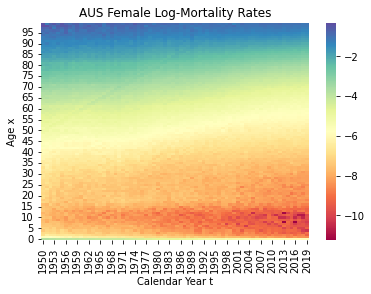

In [8]:
# find min value and max value to set the scale of the label to be consistent between male and female
minvalue = all_mort.logmx.min().min()
maxvalue = all_mort.logmx.max().max()

# pivot data to acceptable form for heatmap
heatmap_data = pd.pivot_table(gender_mort, values = 'logmx', index = 'Age', columns = 'Year')

# plot heatmap
heatmap = sns.heatmap(data = heatmap_data,vmin = minvalue, vmax = maxvalue, cmap = "Spectral").invert_yaxis()

# add title and labels
plt.title(f"{country} {gender} Log-Mortality Rates")
plt.xlabel('Calendar Year t')
plt.ylabel('Age x')

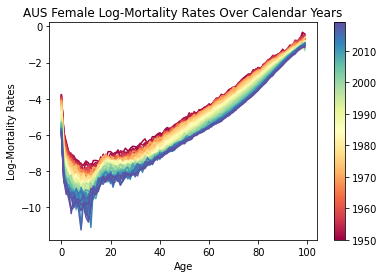

In [9]:
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=heatmap_data.columns.min(), vmax=heatmap_data.columns.max())
colormap = cm.Spectral

# plot
for n in heatmap_data.columns:
    plt.plot(heatmap_data[n], color=colormap(normalize(n)))

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(heatmap_data.columns)
plt.colorbar(scalarmappaple)

# add axis labs
plt.title(f"{country} {gender} Log-Mortality Rates Over Calendar Years")
plt.xlabel('Age')
plt.ylabel('Log-Mortality Rates')

# show the figure
plt.show()

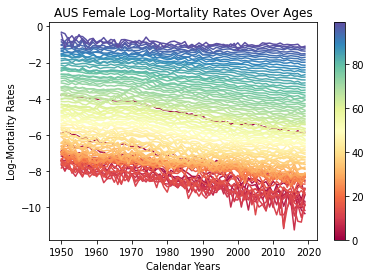

In [10]:
heatmap_data_t = heatmap_data.transpose()

# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=heatmap_data_t.columns.min(), vmax=heatmap_data_t.columns.max())
colormap = cm.Spectral

# plot
for n in heatmap_data_t.columns:
    plt.plot(heatmap_data_t[n], color=colormap(normalize(n)))

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(heatmap_data_t.columns)
plt.colorbar(scalarmappaple)

# add axis labs
plt.title(f"{country} {gender} Log-Mortality Rates Over Ages")
plt.xlabel('Calendar Years')
plt.ylabel('Log-Mortality Rates')

# show the figure
plt.show()

## 4. Split into training, validation and test set

We then split the data into approximately 60% training, 20% validation and 20% test set, split by calendar year. The training set will contain only the observations prioer to the ones from the test set so that no future observations are used in constructing the forecast. This prevents any leaks that may cause a bias in estimation which leads to deviations in prediction error while applying the model to new unseen data.

Our modelling process will be as follows:
1. Each model will be fit the **training set** which consists of data from years 1950,..,1991.
2. The error for each model will be evaluated on the **validation set** which consists of data from years 1992,...,2005.
3. The model with the lowest validation will be selected
4. The error of the final model will then be computed on the **test set** which consists of data from years 2006,...,2019

In [11]:
minYear = gender_mort.Year.min()
maxYear = gender_mort.Year.max()
interval = (maxYear - minYear)/10
traincut = int(minYear + interval * 6)
valcut = int(minYear + interval * 8)

minYear, traincut, valcut, maxYear

(1950, 1991, 2005, 2019)

In [12]:
1991-1950

41

In [13]:
2005-1992

13

In [14]:
2019-2006

13

## 5. Baseline Model: Lee-Carter model

The Lee-Carter model is the most commonly used extrapolative model for mortality forecast.

The model calculates the logarithm of the central death rate $log(m_{x,t})$ at age $x$ in the calendar year $t$ as:
$$log(m_{x,t}) = \mathbb{a}_x + b_x k_t + e_{x,t}$$
where:
- $a_x$ = average age-specific pattern of mortality
- $b_x$ = age-specific patterns of mortality change which indicates the logarithm of the force of mortality at age x to variations in the time index $k_t$
- $k_t$ = time index describing mortality trend over time
- $e_{x,t}$ = error term which is assumed to be homoskedastic and with distribution $N~(0,\sigma_{\epsilon}^2)$

These parameters are then estimated through Ordinary Least Squared estimation by solving based on a matrix of available death rates:
$$arg min_{(b_x)_x,(k_t)_t} \sum_{t,x}(log(M_{t,x}- b_xk_t)^2)$$

MAE RMSE